In [1]:
import csv
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import json
import sys

import sys, os
#path2add = os.path.normpath(os.path.abspath(os.path.join(os.path.dirname(__file__), os.path.pardir, 'dir1')))
#print(os.getcwd())
path2add = os.path.normpath(os.path.abspath(os.path.join(os.getcwd(), os.path.pardir)))
#print(path2add)
if (not (path2add in sys.path)) :
    sys.path.append(path2add)
#sys.path.append("C:/Users/grybk/projects/gratbot/theo_chaser_refactor")
from LinearPredictors import LinearTurnPredictor

data_loc="../logs/"



In [2]:
from TimeSeries import TimeSeries,TrackData

test=TimeSeries()
test.append(10,3)

In [3]:
def load_file(fname):
    f=open(fname,'r')
    headings=TimeSeries(title="Compass Heading",ylabel="Radians")  
    dists=TimeSeries(title="Ultrasonic Distance",ylabel="Distance (m)")
    turn_commands=TimeSeries(title="Turn Commands",ylabel="Magnitude")
    fb_commands=TimeSeries(title="For/Bac Commands",ylabel="Magnitude")
    tracks={}
    first_timestamp=0
    for line in f.readlines():
        dat=json.loads(line)
        timestamp=dat["timestamp"]-first_timestamp
        if first_timestamp==0:
            first_timestamp=timestamp            
            timestamp=0
        if "compass_heading" in dat:
            headings.append(timestamp,dat["compass_heading"])            
        if "command" in dat:
            if dat["command"]["address"]==["drive","translate"]:
                if dat["command"]["value"][0]!=0:
                    fb_commands.append(timestamp,dat["command"]["value"][0])
                if dat["command"]["value"][2]!=0:
                    turn_commands.append(timestamp,dat["command"]["value"][2]*dat["command"]["value"][3])
        if "tracked_objects" in dat:                    
            for obj in dat["tracked_objects"]:
                if obj["id"] not in tracks:
                    tracks[obj["id"]]=TrackData()                                    
                tracks[obj["id"]].append(timestamp,obj["xywh"],obj["last_update"],obj["label"])
        if "ultrasonic_sensor/last_measurement" in dat:
            dists.append(timestamp,dat["ultrasonic_sensor/last_measurement"]["average_distance"])  
    return headings,dists,turn_commands,fb_commands,tracks

C:\Users\grybk\projects\gratbot\theo_chaser_refactor\TimeSeries.py:58: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\grybk\projects\gratbot\theo_chaser_refactor\TimeSeries.py:58: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\grybk\projects\gratbot\theo_chaser_refactor\TimeSeries.py:58: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\grybk\projects\gratbot\theo_chaser_refactor\TimeSeries.py:58: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


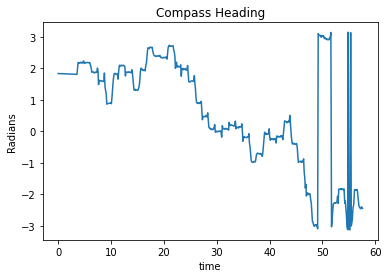

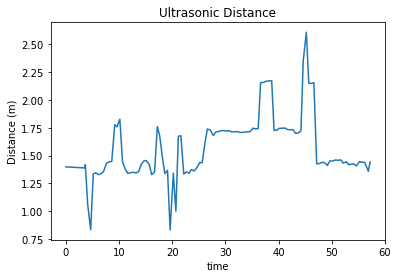

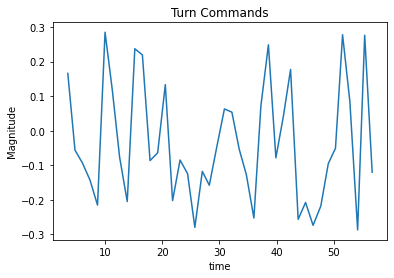

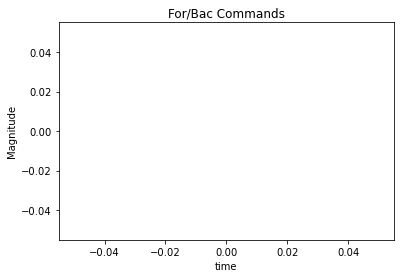

In [4]:
pred=LinearTurnPredictor()
#headings,dists,turn_commands,fb_commands,tracks=load_file(data_loc+"sensor_log_20210120-220516.txt")
headings,dists,turn_commands,fb_commands,tracks=pred.load_log_file(data_loc+"compass_cal_example.txt")
headings.plot()
dists.plot()
turn_commands.plot()
fb_commands.plot()

In [5]:
def wrap_angle(x):
    return (x + np.pi) % (2 * np.pi) - np.pi        

def min_angle_difference(x,y):
        x=wrap_angle(x)
        y=wrap_angle(y)
        a=wrap_angle(x-y)
        #b=wrap_angle(x-y+2*np.pi)
        #c=wrap_angle(x-y-2*np.pi)
        #r=[a,b,c]
        #i=np.argmin(np.abs(r))
        return a


<ipython-input-6-7603afff4f9f>:24: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-6-7603afff4f9f>:24: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-6-7603afff4f9f>:24: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-6-7603afff4f9f>:24: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-6-7603afff4f9f>:29: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


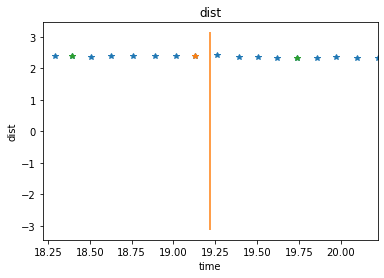

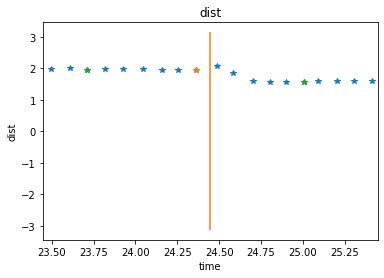

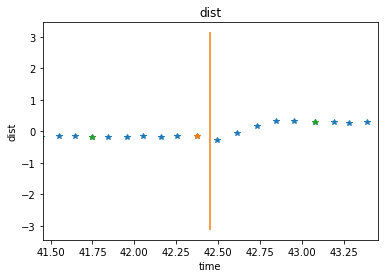

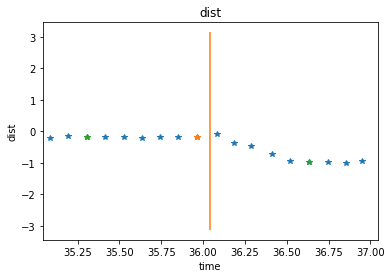

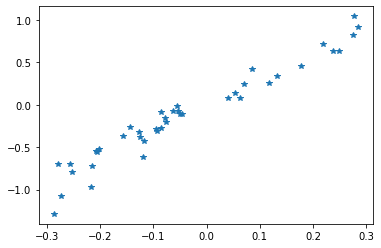

In [6]:
import random
#for each turn action, see if I can find
#1) the compass heading before the turn
#2) The compass heading at least 0.2 s after the turn
# TODO make sure another turn hasn't been called in the interim
#headings_before=headings.find_elems_just_before_times(turn_commands.times)
#headings_after=headings.find_elems_just_after_times(turn_commands.times+0.2)
turns_matching,headings_before,headings_after=headings.extract_bracketing_elements(turn_commands,after_time_min=0.5)

delta_headings=TimeSeries(headings_before.times,min_angle_difference(headings_after.data,headings_before.data))



for i in range(4):
    j=random.choice(range(len(turns_matching)))
    fig, ax = plt.subplots()
    plt.xlim(turns_matching.times[j]-1.0,turns_matching.times[j]+1.0)    
    ax.set(xlabel='time', ylabel='dist',title='dist')
    ax.plot(headings.times,headings.data,'*')
    ax.plot(headings_before.times,headings_before.data,'*')
    ax.plot(headings_after.times,headings_after.data,'*')

    ax.vlines(turns_matching.times,np.min(headings.data),np.max(headings.data),color="C1")
    fig.show()

fig, ax = plt.subplots()    
ax.plot(turns_matching.data,delta_headings.data,'*')
#ax.vlines(turns_t,np.min(headings),np.max(headings),color="C1")
fig.show()

3.12474974074923
0.11958837213984555
0.13121843087399804


<ipython-input-7-129f081dfceb>:12: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  compass_turn_slope=np.asscalar(popt[0])
<ipython-input-7-129f081dfceb>:13: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  compass_turn_slope_unc=np.asscalar(np.sqrt(pcov[0][0]))
<ipython-input-7-129f081dfceb>:14: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  compass_turn_inherent_unc=np.asscalar(sigma)


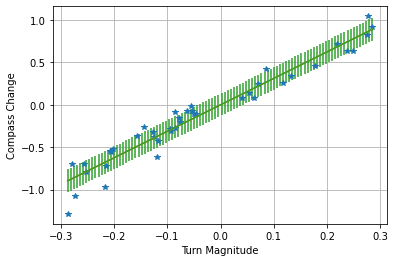

In [7]:
from scipy.optimize import curve_fit 

def fit_compass_calibration(headings,turn_commands):
        turns_matching,headings_before,headings_after=headings.extract_bracketing_elements(turn_commands,after_time_min=0.5)
        delta_headings=TimeSeries(headings_before.times,min_angle_difference(headings_after.data,headings_before.data))

        def lin_fitfcn(x,m):
            return x*m        

        popt, pcov = curve_fit(lin_fitfcn, turns_matching.data, delta_headings.data)
        sigma=np.sqrt(np.sum((lin_fitfcn(turns_matching.data,popt[0])-delta_headings.data)**2)/len(delta_headings))
        compass_turn_slope=np.asscalar(popt[0])
        compass_turn_slope_unc=np.asscalar(np.sqrt(pcov[0][0]))
        compass_turn_inherent_unc=np.asscalar(sigma)
        print(compass_turn_slope)
        print(compass_turn_slope_unc)
        print(compass_turn_inherent_unc)

        test_x=np.linspace(np.min(turns_matching.data),np.max(turns_matching.data),100)
        #test_y,unc=self.predict_compass_from_motion(test_x)
        test_y=popt[0]*test_x
        test_y_unc=np.sqrt( compass_turn_inherent_unc**2+(compass_turn_slope_unc*test_x)**2)        
        fig,ax=plt.subplots()
        ax.plot(turns_matching.data,delta_headings.data,'*')
        ax.plot(test_x,test_y)
        ax.errorbar(test_x,test_y,yerr=test_y_unc)
        ax.set(xlabel="Turn Magnitude",ylabel="Compass Change")
        ax.grid()
        plt.show()

fit_compass_calibration(headings,turn_commands)

C:\Users\grybk\projects\gratbot\theo_chaser_refactor\TimeSeries.py:58: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\grybk\projects\gratbot\theo_chaser_refactor\TimeSeries.py:58: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\grybk\projects\gratbot\theo_chaser_refactor\TimeSeries.py:58: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\grybk\projects\gratbot\theo_chaser_refactor\TimeSeries.py:58: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-58-31f80164bd5c>:28: UserWarning: Matplotlib is currently using module://ipykernel.pylab.back

n tracks 5
match
match
[0.3231320381164551, 0.22536945343017578, 0.21941280364990234, 0.11267471313476562, 0.31618523597717285, 0.21257519721984863, 0.1904914379119873, 0.10774040222167969, 0.13164854049682617, 0.20362424850463867, 0.2044532299041748, 0.22642183303833008, 0.10970807075500488, 0.12064480781555176, 0.20950579643249512, 0.33922767639160156, 0.22439908981323242, 0.20650768280029297, 0.23237919807434082, 0.31615447998046875, 0.10970664024353027, 0.11369538307189941, 0.32210731506347656, 0.2323780059814453, 0.24434685707092285, 0.4038670063018799, 0.41211652755737305, 0.09474635124206543, 0.3181469440460205, 0.21442675590515137, 0.3211400508880615, 0.21143484115600586, 0.20345830917358398, 0.2343733310699463, 0.23136234283447266]


<ipython-input-58-31f80164bd5c>:28: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-58-31f80164bd5c>:81: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-58-31f80164bd5c>:81: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-58-31f80164bd5c>:81: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-58-31f80164bd5c>:81: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-58-31f80164bd5c>:28: UserWarning: Matplotlib 

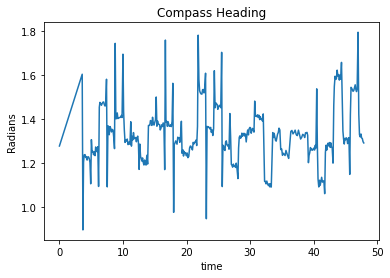

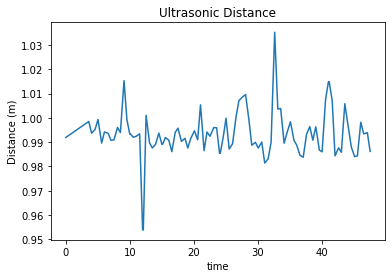

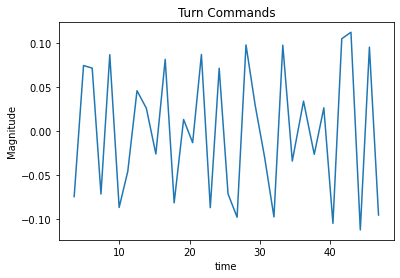

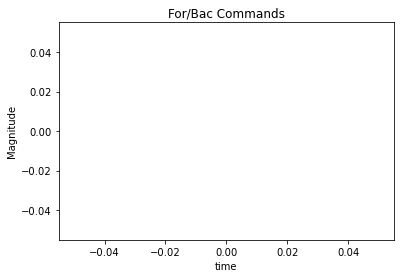

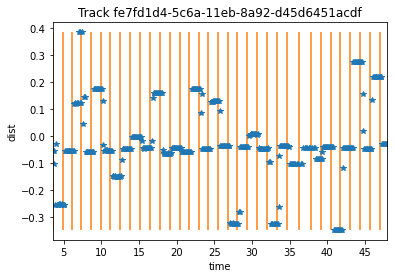

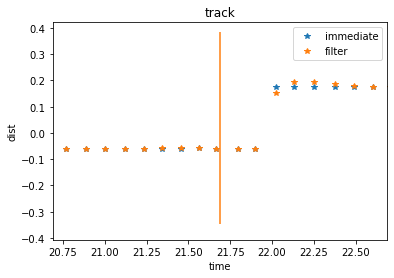

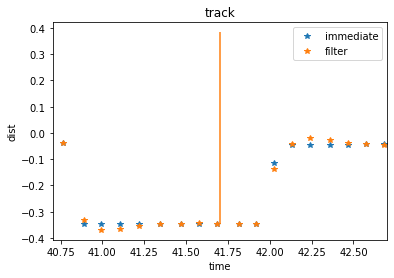

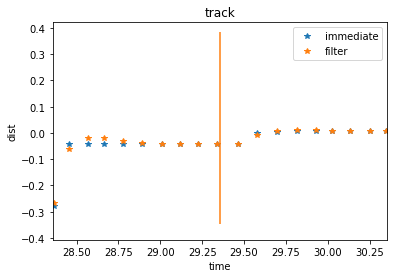

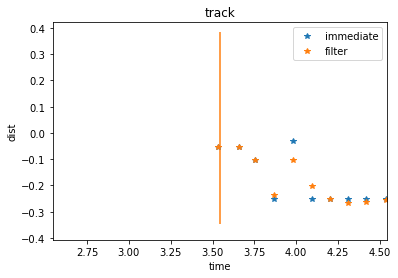

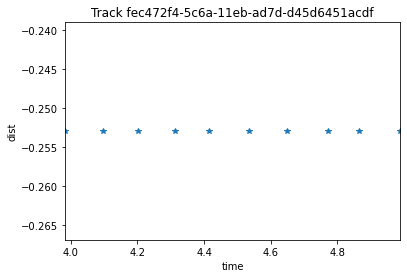

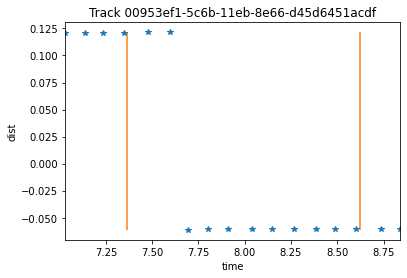

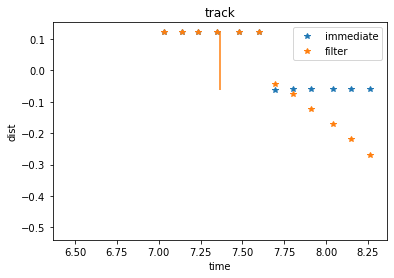

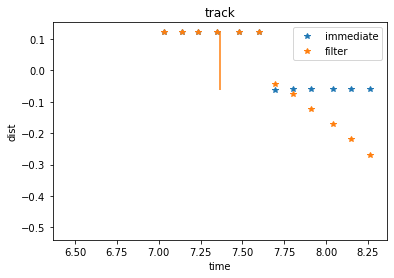

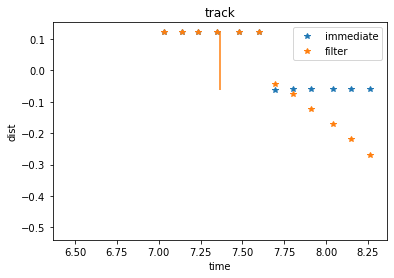

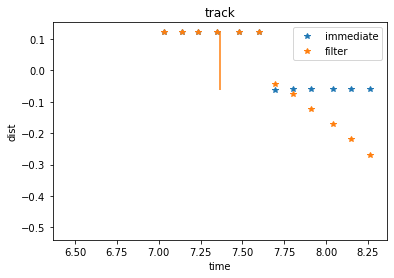

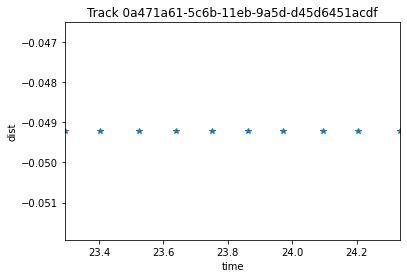

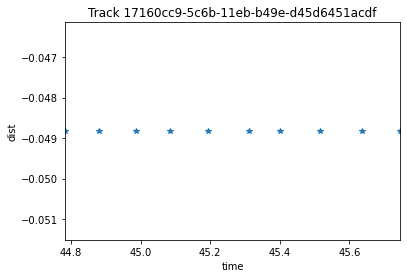

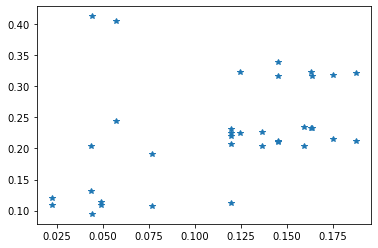

In [58]:
#And now the video tracker
headings,dists,turn_commands,fb_commands,tracks=pred.load_log_file(data_loc+"sensor_log_20210121-203333.txt")
headings.plot()
dists.plot()
turn_commands.plot()
delay_for_jump=[]
delay_for_jump_t=[]
fb_commands.plot()
print("n tracks {}".format(len(tracks)))
#print(tracks)
all_delta_vid=[]
all_turn_mag=[]

for key in tracks:
    #print(tracks[key].last_update)
    xseries=TimeSeries(tracks[key].times,np.array(tracks[key].last_update)[:,0])
    xseries_filter=TimeSeries(tracks[key].times,np.array(tracks[key].xywh)[:,0])

    fig, ax = plt.subplots()
    #plt.xlim(turns_matching.times[j]-1.0,turns_matching.times[j]+1.0)  
    plt.xlim(np.min(xseries.times),np.max(xseries.times))
    ax.set(xlabel='time', ylabel='dist',title="Track {}".format(key))
    ax.plot(xseries.times,xseries.data,'*')
    #ax.plot(headings_before.times,headings_before.data,'*')
    #ax.plot(headings_after.times,headings_after.data,'*')

    ax.vlines(turn_commands.times,np.min(xseries.data),np.max(xseries.data),color="C1")
    fig.show()
    
    turns_matching,trackx_before,trackx_after=xseries.extract_bracketing_elements(turn_commands,after_time_min=0.5)
    if len(turns_matching)==0:
        continue
    print("match")
    delta_vid=TimeSeries(trackx_before.times,min_angle_difference(trackx_after.data,trackx_before.data))
    #print(delta_vid.data)
    #print(turns_matching.data)
    all_delta_vid.extend(delta_vid.data)
    all_turn_mag.extend(turns_matching.data)

    print(delta_vid)
    indices_before=np.searchsorted(xseries.times,turn_commands.times)-1
    indices_after=np.searchsorted(xseries.times,turn_commands.times+0.5)
    
    for i in range(len(indices_before)):
        #print("i {}".format(i))
        #print(indices_after[i])
        #print(len(xseries))
        if indices_after[i]+1>len(xseries):
            continue
        #print("yes")
        #print(indices_before[i],indices_after[i])
        dx=[ xseries.data[j+1]-xseries.data[j] for j in range(indices_before[i],indices_after[i]) ]
        #print("b {} a {}".format(indices_before[i],indices_after[i]))
        #print("len dx {}".format(len(dx)))
        #print(dx)
        if len(dx)==0:
            continue
        #print(len(dx))
        biggest=np.argmax(np.abs(dx))        
        #nth=biggest=xseries.data[j+1]
        #print(biggest)
        deltat=xseries.times[indices_before[i]+biggest]-turn_commands.times[i]
        if deltat<1:       
            delay_for_jump.append(deltat)
            delay_for_jump_t.append(np.abs(turn_commands.data[i]/0.6))
            

    
    for i in range(4):
        j=random.choice(range(len(turns_matching)))
        fig, ax = plt.subplots()
        plt.xlim(turns_matching.times[j]-1.0,turns_matching.times[j]+1.0)    
        ax.set(xlabel='time', ylabel='dist',title='track')
        ax.plot(xseries.times,xseries.data,'*',label="immediate")
        ax.plot(xseries_filter.times,xseries_filter.data,'*',label="filter")
        plt.legend()
        #ax.plot(trackx_before.times,trackx_before.data,'*')
        #ax.plot(trackx_after.times,trackx_after.data,'*')

        ax.vlines(turns_matching.times,np.min(xseries.data),np.max(xseries.data),color="C1")
        fig.show()
print(delay_for_jump)
fig, ax = plt.subplots()
#plt.hist(delay_for_jump)
plt.plot(delay_for_jump_t,delay_for_jump,'*')
fig.show()
#print(delay_for_jump)

<ipython-input-9-29997996615f>:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


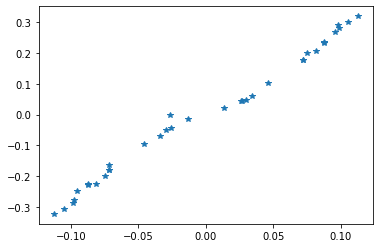

In [9]:
fig, ax = plt.subplots()    
ax.plot(all_turn_mag,all_delta_vid,'*')
#ax.vlines(turns_t,np.min(headings),np.max(headings),color="C1")
fig.show()

<ipython-input-23-0503d34bb032>:22: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  vid_turn_slope=np.asscalar(popt[0])
<ipython-input-23-0503d34bb032>:23: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  vid_turn_slope_unc=np.asscalar(np.sqrt(pcov[0][0]))
<ipython-input-23-0503d34bb032>:24: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  vid_turn_inherent_unc=np.asscalar(sigma)


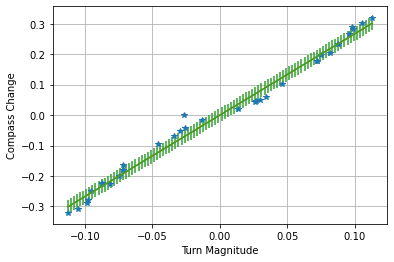

In [23]:
from scipy.optimize import curve_fit 

def fit_vid_calibration(tracks,turn_commands):
    all_delta_vid=[]
    all_turn_mag=[]
    for key in tracks:
        xseries=TimeSeries(tracks[key].times,np.array(tracks[key].last_update)[:,0])
        turns_matching,trackx_before,trackx_after=xseries.extract_bracketing_elements(turn_commands,after_time_min=0.5)
        if len(turns_matching)==0:
            continue
        delta_vid=TimeSeries(trackx_before.times,min_angle_difference(trackx_after.data,trackx_before.data))
        all_delta_vid.extend(delta_vid.data)
        all_turn_mag.extend(turns_matching.data)
            

    def lin_fitfcn(x,m):
        return x*m        

    popt, pcov = curve_fit(lin_fitfcn, all_turn_mag, all_delta_vid)
    sigma=np.sqrt(np.sum((lin_fitfcn(all_turn_mag,popt[0])-all_delta_vid)**2)/len(delta_vid))
    vid_turn_slope=np.asscalar(popt[0])
    vid_turn_slope_unc=np.asscalar(np.sqrt(pcov[0][0]))
    vid_turn_inherent_unc=np.asscalar(sigma)
    print(compass_turn_slope)
    print(compass_turn_slope_unc)
    print(compass_turn_inherent_unc)

    test_x=np.linspace(np.min(all_turn_mag),np.max(all_turn_mag),100)
        #test_y,unc=self.predict_compass_from_motion(test_x)
    test_y=popt[0]*test_x
    test_y_unc=np.sqrt( compass_turn_inherent_unc**2+(compass_turn_slope_unc*test_x)**2)        
    fig,ax=plt.subplots()
    ax.plot(turns_matching.data,delta_headings.data,'*')
    ax.plot(test_x,test_y)
    ax.errorbar(test_x,test_y,yerr=test_y_unc)
    ax.set(xlabel="Turn Magnitude",ylabel="Compass Change")
    ax.grid()
    plt.show()

fit_compass_calibration(headings,turn_commands)

In [67]:
def fit_vid_calibration(tracks,turn_commands,headings):
    all_delta_vid=[]
    all_delta_heading=[]
    for key in tracks:
        xseries=TimeSeries(tracks[key].times,np.array(tracks[key].last_update)[:,0])
        turns_matching,trackx_before,trackx_after=xseries.extract_bracketing_elements(turn_commands,after_time_min=0.5)
        if len(turns_matching)==0:
            continue
        headings_before=headings.find_elems_just_before_times(trackx_before.times)
        headings_after=headings.find_elems_just_after_times(trackx_after.times)                
        delta_headings=TimeSeries(headings_before.times,min_angle_difference(headings_after.data,headings_before.data))                        
        delta_vid=TimeSeries(trackx_before.times,min_angle_difference(trackx_after.data,trackx_before.data))
        all_delta_vid.extend(delta_vid.data)
        all_delta_heading.extend(delta_headings.data)
    all_delta_vid=np.array(all_delta_vid)
    all_delta_heading=np.array(all_delta_heading)

    def lin_fitfcn(x,m):
        return x*m        

    popt, pcov = curve_fit(lin_fitfcn, all_delta_vid, all_delta_heading)
#    sigma=np.sqrt(np.sum((lin_fitfcn(all_turn_mag,popt[0])-all_delta_vid)**2)/len(all_delta_vid))
#    vid_turn_slope=np.asscalar(popt[0])
#    vid_turn_slope_unc=np.asscalar(np.sqrt(pcov[0][0]))
#    vid_turn_inherent_unc=np.asscalar(sigma)
    slope=popt[0]
    slope_unc=np.sqrt(pcov[0][0])
    print(popt[0])
    print(slope_unc)
    #print(compass_turn_inherent_unc)

    test_x=np.linspace(np.min(all_delta_vid),np.max(all_delta_vid),100)
        #test_y,unc=self.predict_compass_from_motion(test_x)
    test_y=popt[0]*test_x
    test_y_unc=np.sqrt( vid_turn_inherent_unc**2+(vid_turn_slope_unc*test_x)**2)        
    fig,ax=plt.subplots()
    ax.plot(all_delta_vid.data,all_delta_heading.data,'*')
#    ax.plot(test_x,test_y)
    ax.errorbar(test_x,test_y,yerr=test_y_unc)
    ax.set(xlabel="Delta Vid",ylabel="Delte Heading")
    ax.grid()
    plt.show()

fit_vid_calibration(tracks,turn_commands,headings)

0.6428282290328127
0.0633059390648043


NameError: name 'vid_turn_inherent_unc' is not defined